### Hybrid Variational Neural Network for Fano fitting (Quantum-Classical Variational Neural Network)

<p>Perform a regression to fit a Fano resonance with Pennylane framework</p>

<p> Let's fit a <a href="https://en.wikipedia.org/wiki/Fano_resonance">Fano resonance</a>, this signal appears on superconducting resonators when photons<sup><a href="https://arxiv.org/abs/2207.03829">[1]</a></sup> interact with spins at low temperatures (from 4K to 10mK in a dilution refrigerator)</p>

#### References:

> https://arxiv.org/abs/2207.03829
>
> https://pennylane.ai/

In [3]:
import pennylane as pnl
pnl.__version__

'0.21.0'

In [2]:
import tensorflow
tensorflow.__version__

'2.5.1'

In [4]:
import keras
keras.__version__

'2.5.0'

In [5]:
import tensorflow.keras
tensorflow.keras.__version__

'2.5.0'

In [1]:
from pennylane.templates import AngleEmbedding, StronglyEntanglingLayers
from pennylane.qnn import KerasLayer
from pennylane import numpy as np
from pennylane import expval, PauliZ, device, qnode

from keras.optimizers import Adam, SGD
from keras.models import Sequential, Model
from keras.layers import Dense
from tensorflow.keras import Input
from tensorflow import split, concat

import pandas as pd
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter
from scipy.signal import detrend
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

%matplotlib inline

plt.rcParams['figure.figsize'] = [10, 7]
%config InlineBackend.figure_format = 'retina'

In [2]:
fano_data = pd.read_csv("./datasets/signal_080_peak_1_fano_adjust.csv")

In [3]:
def func_fano(x, xc, w, q, y0):
    y = y0+A*(2*(x-xc)/w+q)*(2*(x-xc)/w+q)/(2*(x-xc)/w*2*(x-xc)/w+1)/(1+q*q)
    return y

def scale(arr, lvalue = -np.pi, rvalue = np.pi):
    return np.interp(arr, (arr.min(), arr.max()), (lvalue, rvalue))

def remove_outlier(df_in, col_name, quartiles, rng_arr):
    q1 = df_in[col_name].quantile(quartiles[0])
    q3 = df_in[col_name].quantile(quartiles[1])
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-rng_arr[0]*iqr
    fence_high = q3+rng_arr[1]*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

In [4]:
def smooth(data):
    #return data
    #return scipy.ndimage.gaussian_filter(data, sigma=30, mode='reflect', truncate=18.0)
    
    return gaussian_filter(data, sigma=15, mode='reflect', truncate=18.0)
    #return scipy.ndimage.gaussian_filter(data, sigma=15, mode='reflect', truncate=15.0)

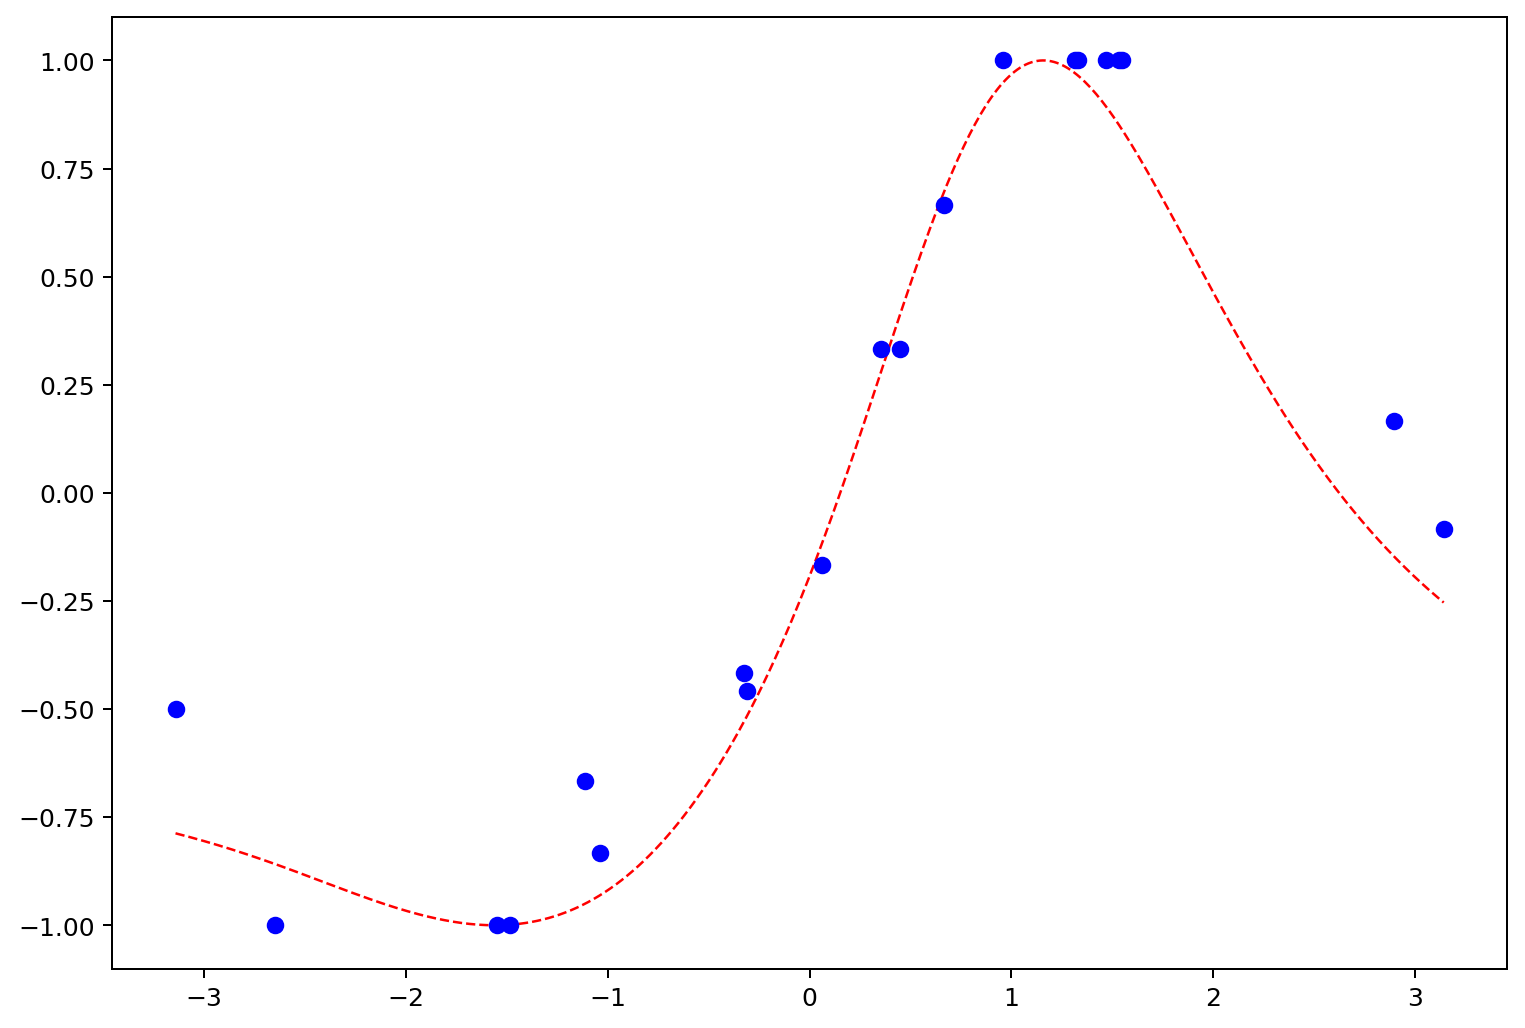

In [5]:
num_samples = 20
eps = 0.2
lb, ub = -1, 1

y0 = fano_data["y0"].values[0]
A = fano_data["A"].values[0]
xc = fano_data["xc"].values[0]
q = fano_data["q"].values[0]
w = fano_data["w"].values[0]

f = lambda x: func_fano(x, xc, w, q, y0)

X_ = fano_data["signal_original_x"].values.reshape(-1,1)

# Create Gaussian distribution (mean = 0, std = 1)
std_scaler = StandardScaler()
std_scaler.fit(X_)
X_ = std_scaler.transform(X_)

#y_ = f(X_)

y_ = fano_data["signal_original_y"].values

# select a better range of data to fit
rng = range(250,700)

X_ = X_.take(rng, axis=0)
y_ = y_.take(rng, axis=0)

# random indices for points selection
#indices = sorted(np.random.choice(range(X_.shape[0]), num_samples, replace=False))

#indices = np.array([19,  40, 156, 159, 173, 175, 191, 207, 213, 253, 358, 359, 448, 543, 559, 613, 651, 657, 737, 754])
indices = [22, 54, 125, 129, 153, 158, 204, 205, 229, 248, 254, 268, 287, 310, 311, 320, 324, 325, 412, 428]

X = X_[indices].reshape(-1,1)
y = y_[indices].reshape(-1,1)

#df = pd.DataFrame(zip(X[:,0].flatten().tolist(), y[:,0].flatten().tolist()), columns = ["X", "y"])
#new_df = remove_outlier(df, "y", [0.25, 0.75], [0.05, 0.05])
#X = new_df["X"].values.reshape(-1,1)
#y = new_df["y"].values.reshape(-1,1)

y = detrend(y)

X = scale(X)
y = scale(y, -1, 1)

X_ = scale(X_)
y_ = scale(y_, -1, 1)

plt.figure(num = "Fano adjust data", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')
plt.plot(X_, y_, "r--", label='Tx signal', linewidth = 1)
plt.plot(X, y, "bo", label = 'Points to fit')
plt.show()

In [6]:
n_qubits = 8
layers = 8
data_dimension = 1

In [7]:
dev = device("default.qubit", wires=n_qubits)

In [8]:
@qnode(dev)
def qnode(inputs, weights):
    
    AngleEmbedding(inputs, wires=range(n_qubits))
    StronglyEntanglingLayers(weights, wires=range(n_qubits))

    return [expval(PauliZ(i)) for i in range(n_qubits)]

In [9]:
def sequential_model():
    
    weight_shapes = {"weights": (layers, n_qubits, 3)}

    layers_arr = []

    layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape = [1]))
    layers_arr.append(KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
    #layers_arr.append(Dense(n_qubits, activation = 'relu', input_shape = [1]))
    #layers_arr.append(KerasLayer(qnode, weight_shapes, output_dim=n_qubits))
    layers_arr.append(Dense(data_dimension, activation="linear"))
    layers_arr.append(Dense(1))

    return Sequential(layers_arr)

In [10]:
def non_sequential_model():
    
    weight_shapes = {"weights": (layers, n_qubits, 3)}
        
    clayer_1 = Dense(n_qubits, activation = 'relu', input_shape = [1])
    qlayer_1 = KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
    qlayer_2 = KerasLayer(qnode, weight_shapes, output_dim=n_qubits)
    clayer_2 = Dense(data_dimension, activation="softmax")

    # construct the model
    inputs = Input(shape=(1,))
    x = clayer_1(inputs)
    x_1, x_2 = split(x, 2, axis=1)
    x_1 = qlayer_1(x_1)
    x_2 = qlayer_2(x_2)
    x = concat([x_1, x_2], axis=1)
    outputs = clayer_2(x)

    return Model(inputs=inputs, outputs=outputs)

In [11]:
#model = non_sequential_model()
model = sequential_model()
    
opt = Adam(learning_rate=0.01)
#opt = SGD(learning_rate=0.01)

model.compile(opt, loss='mse', metrics=["accuracy"])

In [12]:
history = model.fit(X, y, epochs=50, batch_size=5, validation_split = 0.25)

Epoch 1/50
3/3 [==============================] - 15s 5s/step - loss: 1.5223 - accuracy: 0.2000 - val_loss: 0.2506 - val_accuracy: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 14s 5s/step - loss: 0.9884 - accuracy: 0.0667 - val_loss: 0.3889 - val_accuracy: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 14s 5s/step - loss: 0.7112 - accuracy: 0.0000e+00 - val_loss: 0.5197 - val_accuracy: 0.0000e+00
Epoch 4/50
3/3 [==============================] - 14s 5s/step - loss: 0.5702 - accuracy: 0.0000e+00 - val_loss: 0.6228 - val_accuracy: 0.0000e+00
Epoch 5/50
3/3 [==============================] - 14s 5s/step - loss: 0.4959 - accuracy: 0.0000e+00 - val_loss: 0.6571 - val_accuracy: 0.0000e+00
Epoch 6/50
3/3 [==============================] - 14s 5s/step - loss: 0.4728 - accuracy: 0.0000e+00 - val_loss: 0.6589 - val_accuracy: 0.0000e+00
Epoch 7/50
3/3 [==============================] - 14s 5s/step - loss: 0.4384 - accuracy: 0.0000e+00 - val_loss: 0.6320 - val_accurac

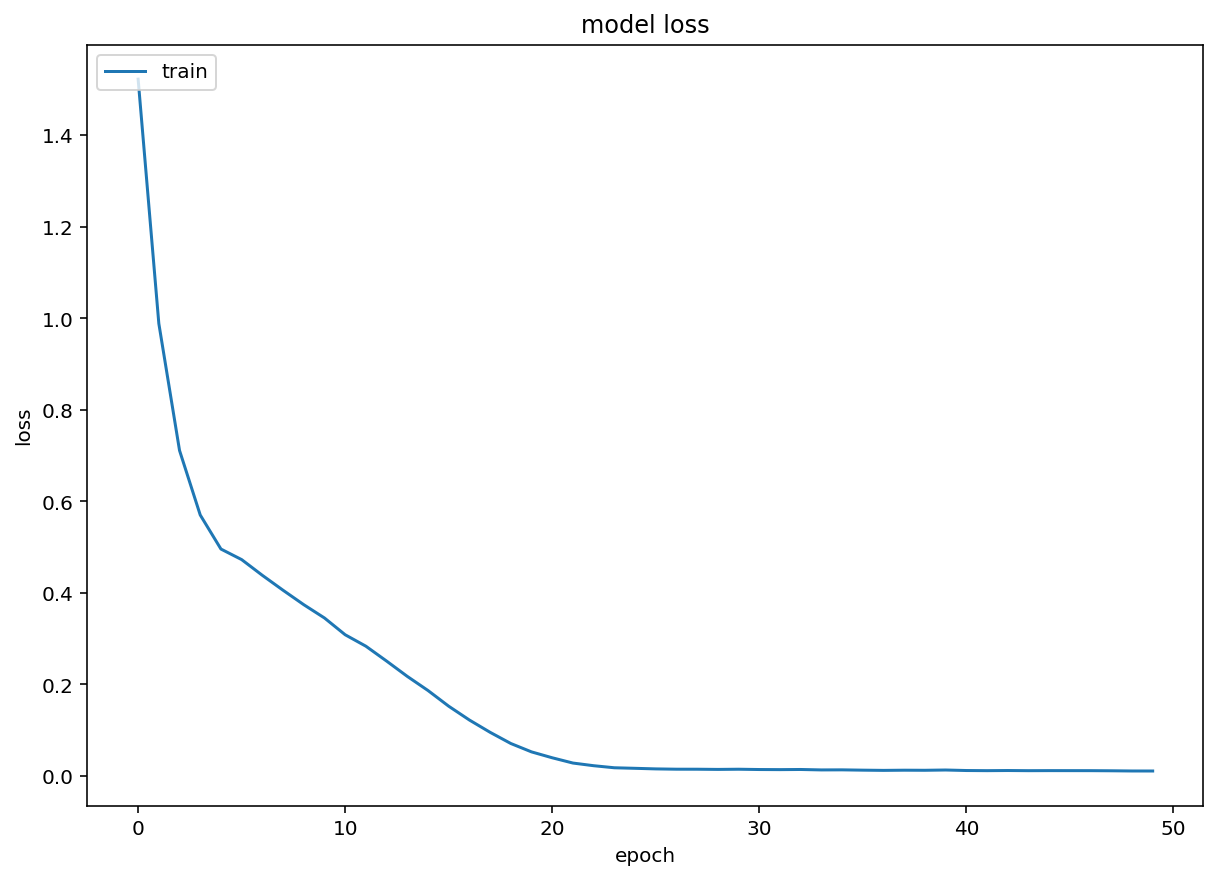

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

In [14]:
y_predict = model.predict(X_)

15/15 [==============================] - 133s 9s/step


In [15]:
y_predict_smooth = smooth(y_predict)

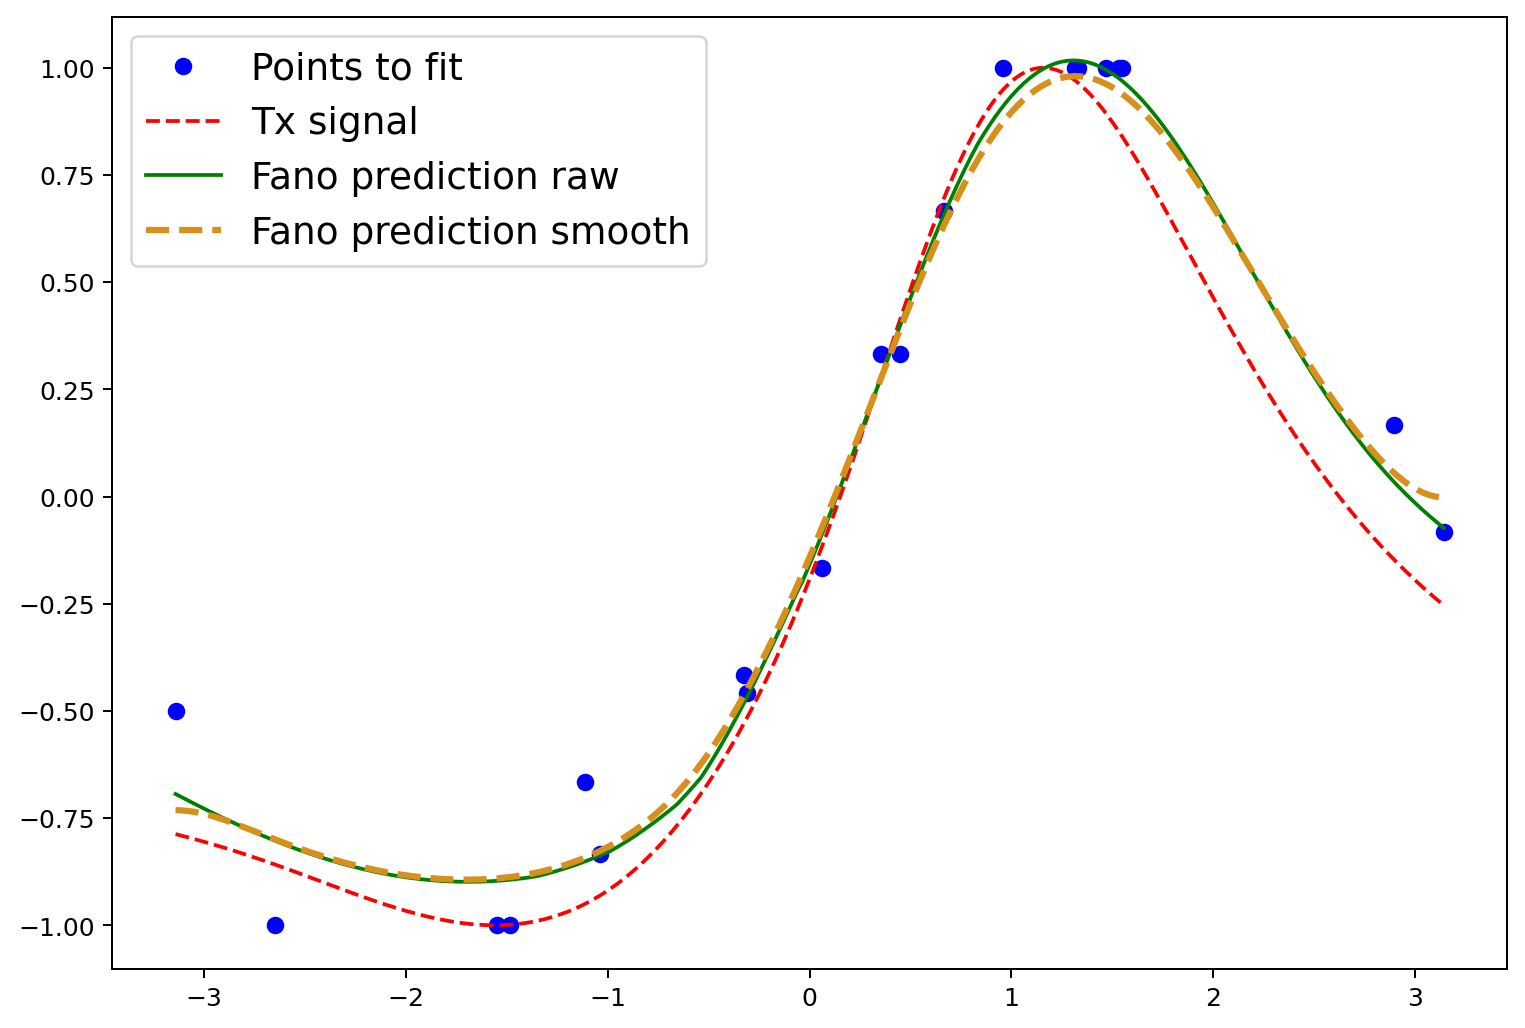

In [16]:
plt.figure(num = "Fano adjust QML 1", figsize = (10, 7), dpi=90, facecolor='w', edgecolor='k')

# plot data
plt.plot(X, y, "bo", label = 'Points to fit')

# plot target function
plt.plot(X_, y_, "r--", label = 'Tx signal')

# plot prediction
plt.plot(X_, y_predict[:,0], "g-", label = 'Fano prediction raw')
plt.plot(X_, y_predict_smooth[:,0], "--", color='#d7901b', linewidth=2.5, label = 'Fano prediction smooth')
plt.legend(loc = 'upper left', fontsize = 15)
plt.show()

In [17]:
print("Score: %.10f" % r2_score(y_, y_predict))   

Score: 0.9734587615
